## Задание 3:
Собрать набор из нескольких десятков картинок и организовать процедуру поиска похожих с помощью:
1. hog и faiss;
2. дескрипторов, полученных от претрейнов CNN на imagenet и faiss;
3. сравнить эффективность полученных реализаций поиска похожих изображений.

In [ ]:
!pip install --q faiss-cpu --no-cache

In [ ]:
import cv2
import faiss
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
from torchvision.models import resnet18
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from PIL import Image
from skimage.feature import hog

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Набор картинок состоит из 100 рандомных кадров сериала "Тьма". Разархивируем датасет:

In [ ]:
!unzip -qq /content/drive/MyDrive/3_сем/CV/images.zip

Переименуем изображения:

In [ ]:
input_folder = "images"
output_folder = "dataset"
photo_number = 1

In [ ]:
for root, _, files in os.walk(input_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            new_name = f"photo_{photo_number}{os.path.splitext(file)[1]}"
            input_path = os.path.join(root, file)

            relative_path = os.path.relpath(root, input_folder)
            output_dir = os.path.join(output_folder, relative_path)
            os.makedirs(output_dir, exist_ok=True)
            output_path = os.path.join(output_dir, new_name)
            os.rename(input_path, output_path)
            photo_number += 1

print(f"Все изображения переименованы и сохранены в папке {output_folder}.")

Все изображения переименованы и сохранены в папке dataset.


Функция для визуализации результатов:

In [ ]:
def visualize_results(test_image_paths, image_paths, I, topn, resolution=224):
  num_queries = len(test_image_paths)

  image_grid = []
  for num_query in range(num_queries):
    paths = [test_image_paths[num_query]]
    paths.extend([image_paths[idx] for idx in I[num_query]])

    image_row = []
    for path in paths:
      image = cv2.imread(path)[..., :3][..., ::-1]
      image = cv2.resize(image, (resolution, resolution))
      image_row.append(image)
    image_row = np.concatenate(image_row, axis=1)
    image_grid.append(image_row)
  image_grid = np.concatenate(image_grid, axis=0)

  return Image.fromarray(image_grid)

Извлечение эмбеддингов изображений с помощью предобученной модели ResNet-18:

In [ ]:
class FeatureExtractor:
  def __init__(self, transform=None, device='cuda:0'):
    self.device = device

    # трансформации для изображений
    self.transform = transform

    # загружаем претрейн модели
    self.model = resnet18(pretrained=True)

    # убираем классифицирующую голову
    self.model = torch.nn.Sequential(*(list(self.model.children())[:-1]))
    self.model = self.model.to(self.device)
    self.model.eval()

  def get_feature(self, image_path):
    # откроем и отмасштабируем изображение
    image = Image.open(image_path)

    # получим тензор
    image_tensor = self.transform(image).unsqueeze(0).to(self.device)

    # получим эмбеддинги
    with torch.no_grad():
      embedding = self.model(image_tensor).cpu().flatten().numpy()

    return embedding

Зафиксируем размер разрешения изображения и путь до датасета:

In [ ]:
resolution = 224
dataset_root = '/content/dataset'

Трансформации изображений:

In [ ]:
transform = transforms.Compose([transforms.Resize((resolution, resolution)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

Пути до изображений:

In [ ]:
exts = ['png', 'jpg', 'JPG', 'JPEG', 'PNG']
image_paths = []
for ext in exts:
  image_paths.extend(glob(os.path.join(dataset_root, f'*.{ext}')))

In [ ]:
# сформировались ли пути до изображений?
image_paths[:10]

['/content/dataset/photo_48.jpg',
 '/content/dataset/photo_27.jpg',
 '/content/dataset/photo_56.jpg',
 '/content/dataset/photo_28.jpg',
 '/content/dataset/photo_9.jpg',
 '/content/dataset/photo_25.jpg',
 '/content/dataset/photo_12.jpg',
 '/content/dataset/photo_47.jpg',
 '/content/dataset/photo_78.jpg',
 '/content/dataset/photo_93.jpg']

Инициализация FeatureExtractor для извлечения признаков:

In [ ]:
fe = FeatureExtractor(transform=transform)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
fe.model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# для хранения эмбеддингов
embeddings = []

# перебираем изображения датасета
for image_path in tqdm(image_paths):
  embedding = fe.get_feature(image_path)
  embeddings.append(embedding)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
vectors = np.array(embeddings).astype('float32')

Размерность эмбеддинга:

In [ ]:
dim = embeddings[0].shape[0]

index = faiss.IndexFlatL2(dim)
#print(index.ntotal)
index.add(vectors)
print(index.ntotal)

100


Изображение для поиска:

In [ ]:
test_image_path = '/content/drive/MyDrive/3_сем/CV/home.jpg'
query = fe.get_feature(test_image_path)[np.newaxis]

Выполним поиск похожих изображений по векторам faiss:

In [ ]:
# строим индекс faiss
index = faiss.index_factory(dim, "IVF10,Flat")

print(index.is_trained)
index.train(vectors)

print(index.is_trained)
print(index.ntotal)
index.add(vectors)
print(index.ntotal)

False
True
0
100


In [ ]:
topn = 5 # 5 ближайших
D, I = index.search(query, topn)

(array([[109.419556, 125.02083 , 151.173   , 179.6119  , 227.95297 ]],
       dtype=float32),
 array([[10, 50, 73,  1, 33]]))

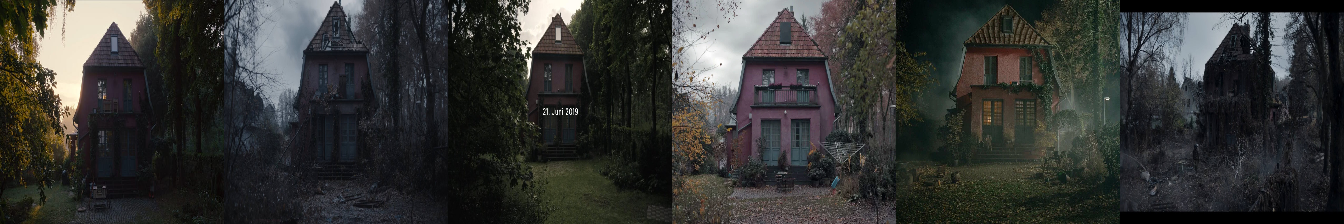

In [ ]:
visualize_results([test_image_path], image_paths, I, topn, resolution=224)

In [ ]:
print("CNN: average distance to neighbors:", np.mean(D))
print(D)

CNN: average distance to neighbors: 158.63565
[[109.419556 125.02083  151.173    179.6119   227.95297 ]]


Извлечение HOG-признаков:

In [ ]:
def extract_hog_features(img_path, resolution=224):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (resolution, resolution))
    features = hog(img,
                   pixels_per_cell=(16, 16),
                   cells_per_block=(2, 2),
                   visualize=False)
    return features

Извлечение HOG-признаков из всех изображений и преобразование их в вектор формата numpy массив:

In [ ]:
hog_features = []
for path in tqdm(image_paths):
    hog_features.append(extract_hog_features(path))

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
hog_vectors = np.array(hog_features).astype('float32')

In [ ]:
hog_dim = hog_vectors[0].shape[0]
hog_index = faiss.IndexFlatL2(hog_dim)
hog_index.add(hog_vectors)

Поиск ближайших изображений для тестового изображения:

In [ ]:
hog_query = extract_hog_features(test_image_path)[np.newaxis]
hog_D, hog_I = hog_index.search(hog_query, topn)

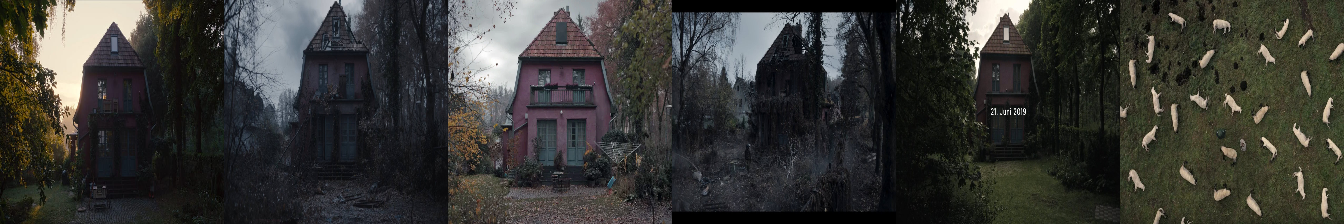

In [ ]:
visualize_results([test_image_path], image_paths, hog_I, topn, resolution=224)

In [ ]:
print("HOG: average distance to neighbors:", np.mean(hog_D))
print(hog_D)

HOG: average distance to neighbors: 46.579613
[[40.091415 46.911278 47.224205 48.505905 50.165253]]


Вывод: CNN лучше захватывает сложные, специфичные для объектов черты в отличие от HOG, что видно при отображении результатов. Также это мы можем наблюдать из значений средних расстояний (у CNN они выше).